# Model training with KNC
Derived from exploratory_model_training.ipynb but removing pixel rows 41-128 for faster training

In [1]:
# Imports
# Imports
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
# Import np arrays
X = np.load('../data/processed/pln_X_small_features_raw_128x128.npy')
y = np.load('../data/processed/pln_y_small_labels.npy')

In [3]:
# Data pipeline
# Remove row 41-128 based on feature importance
X_reshape = X.reshape(-1, 128, 128)
X_top40 = X_reshape[:, :40, :]
X_top40_flat = X_top40.reshape(X_top40.shape[0], -1)


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top40_flat, y, test_size=0.20, 
    random_state=42,
    stratify=y
)

In [5]:
# Scaling
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Setting Param grid for KNC

param_grid = {
    'n_neighbors': [2, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}


In [7]:
# Initializing model
knc = KNeighborsClassifier()
grid = GridSearchCV(knc, param_grid, n_jobs=-1)


In [8]:
# Fitting GridSearchCV
grid.fit(X_trained_scaled, y_train)


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['minkowski', 'euclidean'], 'n_neighbors': [2, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,2


In [9]:
results = pl.DataFrame(grid.cv_results_)
top3 = results.sort("mean_test_score", descending=True).head(3)
for row in top3.iter_rows(named=True):
    print(f"Score: {row['mean_test_score']:.4f}, Params: {row['params']}")
best_rfc = grid.best_estimator_

Score: 0.9400, Params: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
Score: 0.9400, Params: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Score: 0.9300, Params: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'uniform'}


              precision    recall  f1-score   support

           0       0.94      0.99      0.97        86
           1       0.90      0.64      0.75        14

    accuracy                           0.94       100
   macro avg       0.92      0.82      0.86       100
weighted avg       0.94      0.94      0.94       100



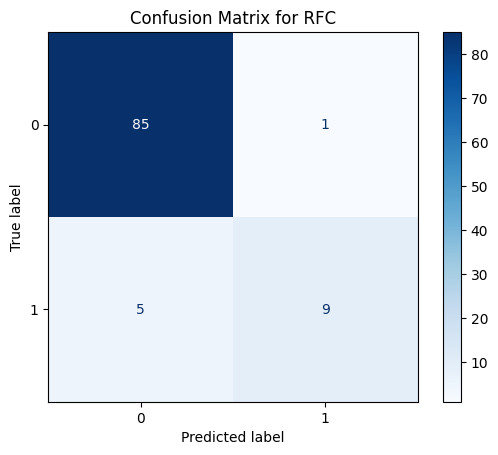

In [10]:
# Score and Confusion Matrix with lower threshold
y_proba = best_rfc.predict_proba(X_test_scaled)[:, 1]
threshold = 0.2
y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for RFC")
plt.show()


voting?

Kolla vilka prediktioner som RFC och KNC predikterar rätt respektive fel för att se om de hittar samma eller inte.